In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../')
import utils.lec3_graphs as gfx

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10, 6)

## Ejemplo Bayes

In [6]:
def bayes_solver(likelihood = .95, prior = 0.01, evidence = 0.1):
    return round(likelihood * prior / evidence, 3)

In [7]:
bayes_solver()

0.095

In [8]:
bayes_solver(evidence=.20)

0.047

In [9]:
bayes_solver(prior=0.2, evidence=.2)

0.95

## Ejemplo Naive Bayes

In [16]:
df = pd.read_csv('../../data/un2_ucbadmissions.csv').drop(columns='Unnamed: 0')
print(df.sample(4))

       Admit  Gender Dept  Freq
5   Rejected    Male    B   207
20  Admitted    Male    F    22
23  Rejected  Female    F   317
0   Admitted    Male    A   512


In [17]:
df_deagg = gfx.deaggregate_statistics(df)
df_deagg.shape[0] == sum(df['Freq'])

True

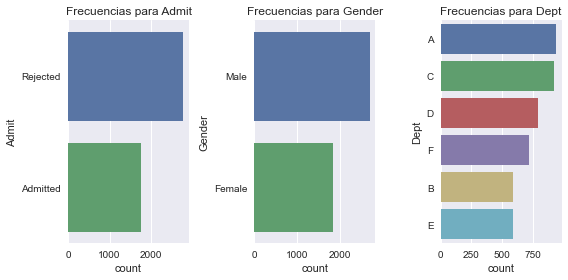

In [18]:
plt.figure(figsize=(8, 4))
for n, i in enumerate(['Admit', 'Gender', 'Dept']):
    plt.subplot(1, 3, n + 1)
    sns.countplot(y= df_deagg[i], order = df_deagg[i].value_counts().index)
    plt.title('Frecuencias para {}'.format(i))
    plt.tight_layout()

In [13]:
for _ , i in df_deagg.iteritems():
    print(i.value_counts('%'),"\n")

Rejected    0.61224
Admitted    0.38776
Name: Admit, dtype: float64 

Male      0.594565
Female    0.405435
Name: Gender, dtype: float64 

A    0.206142
C    0.202828
D    0.174989
F    0.157755
B    0.129253
E    0.129032
Name: Dept, dtype: float64 



## Ejemplo Naive Bayes
Clasificador SPAM

![otro](ej_naive.jpeg)

* 100 Correos
* 75 NO SPAM y 25 son SPAM

DATOS
* Incluyen la palabra Barato
* No incluyen la palabra Barato

Calcular la probabilidad de SPAM cuando un correo tiene la palabra BARATO y COMPRAR

$P(S|B,C) = \frac{P(B,C | S) P(S)}{P(B,C)}$

$P(S|B,C) = \frac{P(B|S)P(C|S)P(S)}{P(B,C|S)P(S)+P(B,C|N)P(N)}$

$P(S|B,C) = \frac{P(B|S)P(C|S)P(S)}{P(B|S)P(C|S)P(S)+P(B|N)P(C|N)P(N)}$

## Modelamiento Naive Bayes

In [21]:
df_deagg['Admit'].value_counts('%')

Rejected    0.61224
Admitted    0.38776
Name: Admit, dtype: float64

In [23]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# instanciamos el objeto
lbl = LabelEncoder()
# Implementamos el método fit_transform para actualizar y sobreescribir cada columna de atributos
df_deagg['Gender'] = lbl.fit_transform(df_deagg['Gender'])
df_deagg['Admit'] = lbl.fit_transform(df_deagg['Admit'])
# posteriormente, eliminamos la columna Dept
df_deagg = pd.concat([df_deagg, pd.get_dummies(df_deagg['Dept'], prefix='dept')], axis=1).drop(columns='Dept')

In [24]:
df_deagg['Admit'].value_counts('%')

1    0.61224
0    0.38776
Name: Admit, dtype: float64

In [25]:
from sklearn.model_selection import train_test_split

X_train_mat, X_test_mat, y_train_vec, y_test_vec = train_test_split(df_deagg.loc[:, 'Gender':'dept_F'],
                                                                    df_deagg['Admit'],
                                                                    test_size=.30,
                                                                    random_state=11238)
X_train_mat.shape

(3168, 7)

In [26]:
nb_classifier = BernoulliNB()
nb_classifier.fit(X_train_mat, y_train_vec)

BernoulliNB()

## Evaluacion

In [27]:
nb_prob_pred = nb_classifier.predict_proba(X_test_mat)
nb_prob_pred[0]

array([0.62774266, 0.37225734])

In [28]:
nb_class_pred = nb_classifier.predict(X_test_mat)
nb_class_pred[0]

0

In [29]:
from sklearn.metrics import confusion_matrix

y_hat = nb_classifier.predict(X_test_mat)

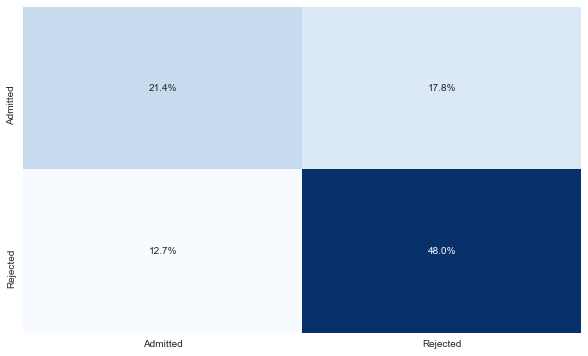

In [30]:
cnf = confusion_matrix(y_test_vec, y_hat)/len(y_test_vec)

target_label = ['Admitted', 'Rejected']

sns.heatmap(cnf, xticklabels=target_label, yticklabels=target_label, annot=True, fmt=".1%", cbar=False, cmap='Blues');

In [31]:
from sklearn.metrics import classification_report
# generar un reporte de métricas de precisión, recall y f1
print(classification_report(y_test_vec, y_hat))

              precision    recall  f1-score   support

           0       0.63      0.55      0.58       533
           1       0.73      0.79      0.76       825

    accuracy                           0.69      1358
   macro avg       0.68      0.67      0.67      1358
weighted avg       0.69      0.69      0.69      1358



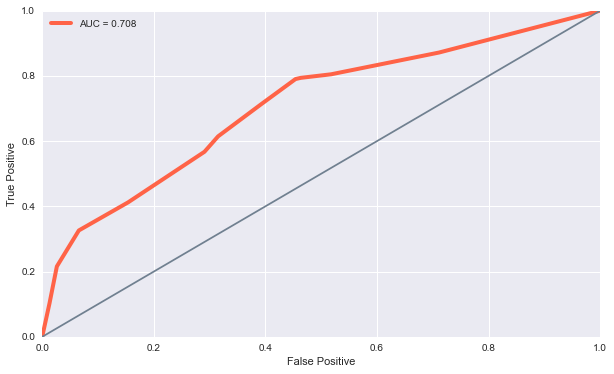

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score


y_hat_pr = nb_classifier.predict_proba(X_test_mat)[:,1]
fpr, tpr, _ = roc_curve(y_test_vec, y_hat_pr)
auc = round(roc_auc_score(y_test_vec, y_hat_pr), 3)
plt.plot(fpr, tpr, label="AUC = {}".format(auc), color='tomato', lw=4)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.axis([0, 1, 0, 1])

plt.plot([0, 1], [0, 1], color='slategrey')
plt.legend();

In [33]:
gfx.compare_priors(X_train=X_train_mat,
                   X_test=X_test_mat,
                   y_train=y_train_vec,
                   y_test=y_test_vec,
                   prior=[0.39, 0.61])

A priori: [0.39, 0.61]
Accuracy: 0.694
Recall: 0.79
Precision: 0.729
F1: 0.759
AUC: 0.708



In [34]:
gfx.compare_priors(X_train=X_train_mat,
                   X_test=X_test_mat,
                   y_train=y_train_vec,
                   y_test=y_test_vec,
                   prior=[.5, .5])

A priori: [0.5, 0.5]
Accuracy: 0.672
Recall: 0.713
Precision: 0.738
F1: 0.725
AUC: 0.708



In [35]:
gfx.compare_priors(X_train=X_train_mat,
                   X_test=X_test_mat,
                   y_train=y_train_vec,
                   y_test=y_test_vec,
                   prior=[.8, .2])

A priori: [0.8, 0.2]
Accuracy: 0.513
Recall: 0.216
Precision: 0.927
F1: 0.35
AUC: 0.708



In [36]:
gfx.compare_priors(X_train=X_train_mat,
                   X_test=X_test_mat,
                   y_train=y_train_vec,
                   y_test=y_test_vec,
                   prior=[.17, .83])

A priori: [0.17, 0.83]
Accuracy: 0.643
Recall: 0.872
Precision: 0.655
F1: 0.748
AUC: 0.708

